# Declare some variables


In [1]:
train_days=range(6+2)
test_days=[8,9]
basic_set_rows_in_dataset=range(40)
label_row_in_dataset=148
sequence_length = 100
learning_rate=0.001
learning_rate_decay=0
batch_size=50
normalize=True
epoch=100

# Implement the model


In [2]:
from mypkg.model_implementations import Conv1D_1st_try

Using TensorFlow backend.
/Users/liyeukhou/opt/anaconda3/envs/gradProj/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/liyeukhou/opt/anaconda3/envs/gradProj/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/liyeukhou/opt/anaconda3/envs/gradProj/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.in

# Preparation for Training and Testing





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100, 40)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 100, 16)           1296      
_________________________________________________________________
activation_1 (Activation)    (None, 100, 16)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 100, 16)           528       
_________________________________________________________________
activation_2 (Activation)    (None, 100, 16)           0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 100, 16)           528       
_____________________

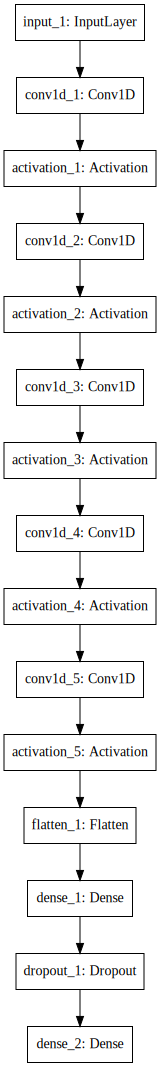

In [3]:
# Load the required packages
from keras.optimizers import Adam
from keras.engine.network import Network
from keras.utils.vis_utils import plot_model, model_to_dot
from IPython.core.display import SVG

# Build the model’s graph
first_model_of_CNN1D = Conv1D_1st_try(input_shape=(sequence_length, len(basic_set_rows_in_dataset)))

# Compile the model to Configure the learning process
first_model_of_CNN1D.compile(optimizer=Adam(lr=learning_rate, decay=learning_rate_decay), loss='categorical_crossentropy', metrics=['accuracy'])

# Print the details of layers in a table with the sizes of its inputs/outputs
first_model_of_CNN1D.summary()

# Plot graph in a nice layout
plot_model(model=first_model_of_CNN1D, to_file='first_model_of_RNN.png')
SVG(data=model_to_dot(model=first_model_of_CNN1D).create(prog='dot', format='svg'))

# Generate .pkl files from dataset (Optional)

In [ ]:
# Load the required packages
from numpy.lib.npyio import save

from mypkg.generate_pkl import convert_multiple_days_data_to_a_dataframe
train_dataframe=convert_multiple_days_data_to_a_dataframe(selected_train_or_test_days=train_days)
train_dataframe.to_pickle(path='train_dataframe.pkl')
test_dataframe=convert_multiple_days_data_to_a_dataframe(selected_train_or_test_days=test_days)
test_dataframe.to_pickle(path='test_dataframe.pkl')

from mypkg.generate_pkl import offset_for_each_stock_each_day
train_offset=offset_for_each_stock_each_day(selected_train_or_test_days=train_days)
save(file='train_offset',arr=train_offset)
test_offset=offset_for_each_stock_each_day(selected_train_or_test_days=test_days)
save(file='test_offset',arr=test_offset)

# Retrieve from saved .pkl files


In [4]:
# Load the required packages
from pandas.io.pickle import read_pickle
from keras.utils.np_utils import to_categorical
from numpy.lib.npyio import load


train_dataframe = read_pickle(path='train_dataframe.pkl')
test_dataframe = read_pickle(path='test_dataframe.pkl')
train_offset = load(file='train_offset.npy')
# print(type(train_offset))
# print(train_offset.shape)
# print(train_offset)
test_offset = load(file='test_offset.npy')

# Load the dataset


In [5]:
X_train = train_dataframe.iloc[:, basic_set_rows_in_dataset].values  # 提取前40列所有行并转换为numpy形式
Y_train = to_categorical(y=train_dataframe.iloc[:, label_row_in_dataset].values - 1)  # 将真实值转化为0-1向量,向前预测5个period, 用不用-1?
X_test = test_dataframe.iloc[:, basic_set_rows_in_dataset].values
Y_test = to_categorical(y=test_dataframe.iloc[:, label_row_in_dataset].values - 1)

from mypkg.batch_generators import batch_generator_for_RNN

# Training


In [6]:
# Load the required packages
from keras.callbacks import TensorBoard, ModelCheckpoint

from mypkg.batch_counter import batches_amount_per_epoch

# Train the model
a_history_object = first_model_of_CNN1D.fit_generator(
    generator=batch_generator_for_RNN(normalize=normalize, X_dataset=X_train,Y_dataset=Y_train,offset=train_offset,sequence_length=sequence_length,batch_size=batch_size),
    validation_data=batch_generator_for_RNN(normalize=normalize, X_dataset=X_test,Y_dataset=Y_test,offset=test_offset,sequence_length=sequence_length,batch_size=batch_size),
    steps_per_epoch=batches_amount_per_epoch(offset=train_offset,sequence_length=sequence_length,batch_size=batch_size),
    validation_steps=batches_amount_per_epoch(offset=test_offset,sequence_length=sequence_length,batch_size=batch_size),
    epochs=epoch,
    verbose=2,
    callbacks=[TensorBoard(write_images=True),
               ModelCheckpoint(filepath='E:\liyeukhou\graduation_project\saved_models\weights.{epoch:02d}-{val_loss:.2f}.h5', monitor='loss',save_best_only=True)])

# Auto save the entire model to a HDF5 file
first_model_of_CNN1D.save(filepath='CNN1D.h5')

Epoch 1/100
 - 44s - loss: 1.0544 - acc: 0.4035 - val_loss: 1.1206 - val_acc: 0.3507
Epoch 2/100
 - 41s - loss: 1.0497 - acc: 0.4050 - val_loss: 1.1072 - val_acc: 0.3095
Epoch 3/100
 - 41s - loss: 1.0493 - acc: 0.4053 - val_loss: 1.1144 - val_acc: 0.3507
Epoch 4/100
 - 42s - loss: 1.0494 - acc: 0.4081 - val_loss: 1.1042 - val_acc: 0.3507
Epoch 5/100
 - 43s - loss: 1.0487 - acc: 0.4083 - val_loss: 1.1594 - val_acc: 0.3507
Epoch 6/100
 - 42s - loss: 1.0483 - acc: 0.4101 - val_loss: 1.1121 - val_acc: 0.3507
Epoch 7/100
 - 62s - loss: 1.0482 - acc: 0.4113 - val_loss: 1.1074 - val_acc: 0.3507
Epoch 8/100
 - 66s - loss: 1.0476 - acc: 0.4097 - val_loss: 1.1051 - val_acc: 0.3180
Epoch 9/100
 - 70s - loss: 1.0478 - acc: 0.4113 - val_loss: 1.1248 - val_acc: 0.3507
Epoch 10/100
 - 70s - loss: 1.0486 - acc: 0.4085 - val_loss: 1.1075 - val_acc: 0.3210
Epoch 11/100
 - 72s - loss: 1.0437 - acc: 0.4158 - val_loss: 1.2110 - val_acc: 0.3341
Epoch 12/100
 - 74s - loss: 1.0063 - acc: 0.4587 - val_loss: 1.

# Make sure my model is learning by monitoring the tendency of loss

Text(0, 0.5, 'Cost')

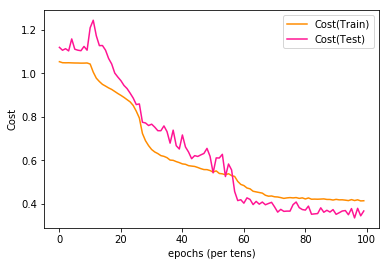

In [7]:
# Load the required packages
import matplotlib.pyplot as pyplot
%matplotlib inline

pyplot.figure()
pyplot.plot(a_history_object.history['loss'], color='darkorange', ls='-', label='Cost(Train)')
pyplot.plot(a_history_object.history['val_loss'], color='deeppink', ls='-', label='Cost(Test)')
pyplot.legend()
pyplot.xlabel(xlabel='epochs (per tens)')
pyplot.ylabel(ylabel='Cost')

# Restore saved model (Optional)

In [8]:
# Load the required packages
from keras.models import load_model

# Recreate the exact same model, including its weights and the optimizer
restored_model = load_model(filepath='CNN1D.h5')
print('Model restored.')

Model restored.


# Testing


In [9]:
# Load the required packages
from keras.engine.training import Model
from numpy.core.multiarray import concatenate
from numpy.core._multiarray_umath import ndarray

train_data=batch_generator_for_RNN(normalize=normalize, X_dataset=X_train,Y_dataset=Y_train,offset=train_offset,sequence_length=sequence_length,batch_size=batch_size)
validation_data=batch_generator_for_RNN(normalize=normalize, X_dataset=X_test,Y_dataset=Y_test,offset=test_offset,sequence_length=sequence_length,batch_size=batch_size)
steps_per_epoch=batches_amount_per_epoch(offset=train_offset,sequence_length=sequence_length,batch_size=batch_size)
validation_steps=batches_amount_per_epoch(offset=test_offset,sequence_length=sequence_length,batch_size=batch_size)

Y_train_true_predictions=[]
Y_hat_train_predictions=[]
Y_test_true_predictions=[]
Y_hat_test_predictions=[]

for each_step in range(int(x=steps_per_epoch)):
    temp=next(train_data)  # 长为2的tuple
    Y_train_true_predictions.append(temp[1]) # for几次长度就是几，就是直接把temp[1]这个真实值ndarray附到list里去了
    Y_hat_train_predictions.append(restored_model.predict(x=temp[0]))   # 同上，但是附的是拿[0]计算出来的预测值

for each_step in range(int(x=validation_steps)):
    temp=next(validation_data)
    Y_test_true_predictions.append(temp[1])
    Y_hat_test_predictions.append(restored_model.predict(x=temp[0]))

Y_train_true_predictions=concatenate(Y_train_true_predictions).reshape(-1,3)  # list变ndarray
Y_hat_train_predictions=concatenate(Y_hat_train_predictions).reshape(-1,3)    # list变ndarray
Y_test_true_predictions=concatenate(Y_test_true_predictions).reshape(-1,3)
Y_hat_test_predictions=concatenate(Y_hat_test_predictions).reshape(-1,3)

# Assessment


In [10]:
# Load the required packages
from numpy.core.fromnumeric import argmax
from sklearn.metrics.classification import classification_report,cohen_kappa_score

print('-----How well have we done on training data-----')
y=argmax(Y_train_true_predictions,axis=1)
y_hat=argmax(Y_hat_train_predictions,axis=1)
print(classification_report(y_true=y,y_pred=y_hat))
Cohens_kappa_coefficient=cohen_kappa_score(y1=y,y2=y_hat)
print(f'Cohen Kappa Score = {Cohens_kappa_coefficient}')

print()

print('-----How well have we done on test data-----')
y=argmax(Y_test_true_predictions,axis=1)
y_hat=argmax(Y_hat_test_predictions,axis=1)
print(classification_report(y_true=y,y_pred=y_hat))
Cohens_kappa_coefficient=cohen_kappa_score(y1=y,y2=y_hat)
print(f'Cohen Kappa Score = {Cohens_kappa_coefficient}')

-----How well have we done on training data-----
              precision    recall  f1-score   support

           0       0.87      0.93      0.89    120347
           1       0.86      0.81      0.83     69882
           2       0.92      0.88      0.90    116039

   micro avg       0.88      0.88      0.88    306268
   macro avg       0.88      0.87      0.88    306268
weighted avg       0.88      0.88      0.88    306268

Cohen Kappa Score = 0.8200314233591146

-----How well have we done on test data-----
              precision    recall  f1-score   support

           0       0.86      0.91      0.89     29147
           1       0.87      0.87      0.87     26310
           2       0.92      0.86      0.89     27662

   micro avg       0.88      0.88      0.88     83119
   macro avg       0.88      0.88      0.88     83119
weighted avg       0.88      0.88      0.88     83119

Cohen Kappa Score = 0.8241837136244413


# Predictor Visualisation

In [11]:
# Load the required packages
from numpy.lib.function_base import average
from matplotlib.pyplot import title
import matplotlib.pyplot as pyplot
%matplotlib inline

up_movement_contributor=[]
down_movement_contributor=[]

train_data=batch_generator_for_RNN(normalize=normalize, X_dataset=X_train,Y_dataset=Y_train,offset=train_offset,sequence_length=sequence_length,batch_size=batch_size)

for each_batch in range(int(x=steps_per_epoch)):
    temp=next(train_data)[0]    # ???
    # print(type(next(train_data)[0]))
    # print(next(train_data)[0].shape)
    # print(next(train_data)[0])
    y_hat_train=restored_model.predict(x=temp)
    # print(y_hat_train)
    # print()
    up_movement_contributor.append(temp[argmax(a=y_hat_train[:,0])])
    # print(argmax(a=y_hat_train[:,0]))
    # print()
    down_movement_contributor.append(temp[argmax(a=y_hat_train[:,2])])
    # print(argmax(a=y_hat_train[:,2]))
    # print()

# print(type(up_movement_contributor))
# print(len(up_movement_contributor))
# print(up_movement_contributor)

In [12]:
up_movement_contributor_avg=average(a=up_movement_contributor,axis=0)
# print(type(up_movement_contributor_avg))
# print(up_movement_contributor_avg.shape)
# print(up_movement_contributor_avg)
down_movement_contributor_avg=average(a=down_movement_contributor,axis=0)

Text(0.5, 1.0, 'volume at bid side')

<Figure size 432x288 with 0 Axes>

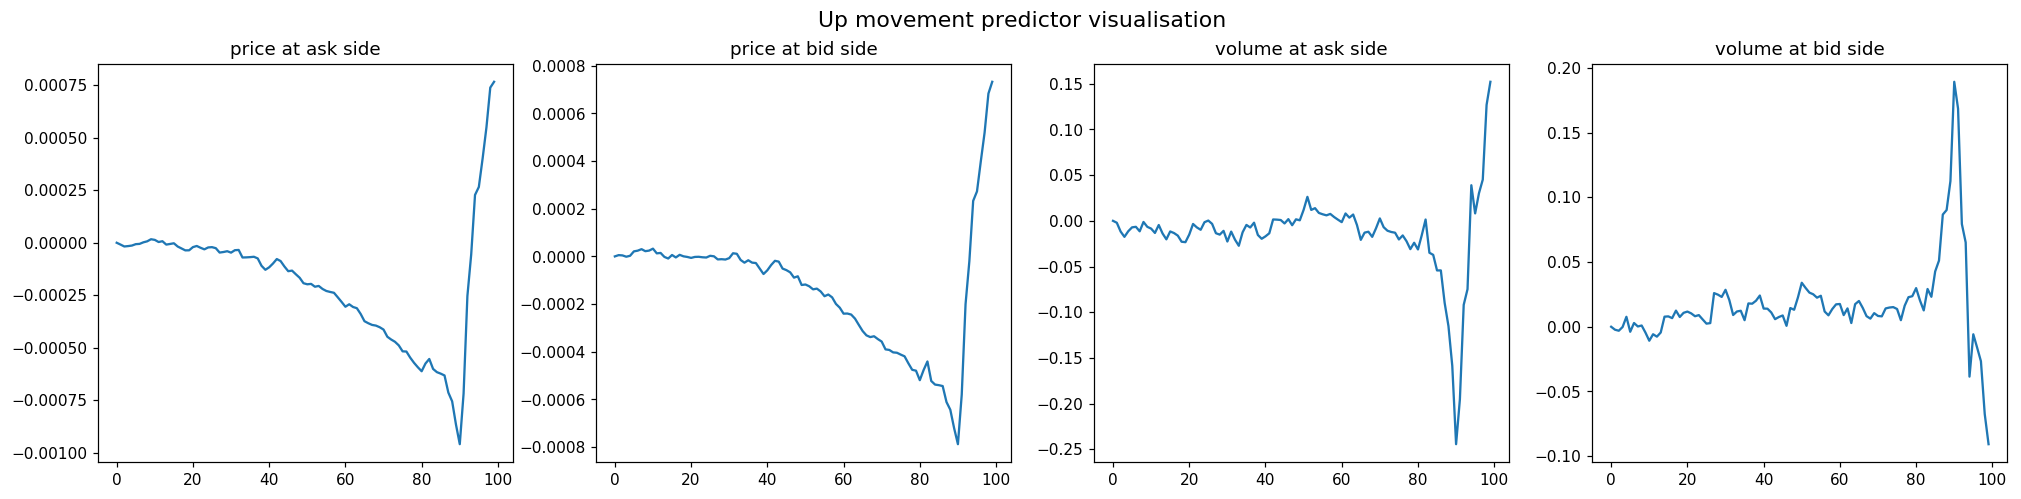

In [13]:
pyplot.tight_layout()

pyplot.figure(figsize=(22.4,4.8),dpi=110)
pyplot.suptitle(t="Up movement predictor visualisation",fontsize='x-large')

pyplot.subplot(1,4,1)
pyplot.plot(up_movement_contributor_avg[:,0], ls='-')
title(label='price at ask side')

pyplot.subplot(1,4,2)
pyplot.plot(up_movement_contributor_avg[:,2], ls='-')
title(label='price at bid side')

pyplot.subplot(1,4,3)
pyplot.plot(up_movement_contributor_avg[:,1], ls='-')
title(label='volume at ask side')

pyplot.subplot(1,4,4)
pyplot.plot(up_movement_contributor_avg[:,3], ls='-')
title(label='volume at bid side')

Text(0.5, 1.0, 'volume at bid side')

<Figure size 432x288 with 0 Axes>

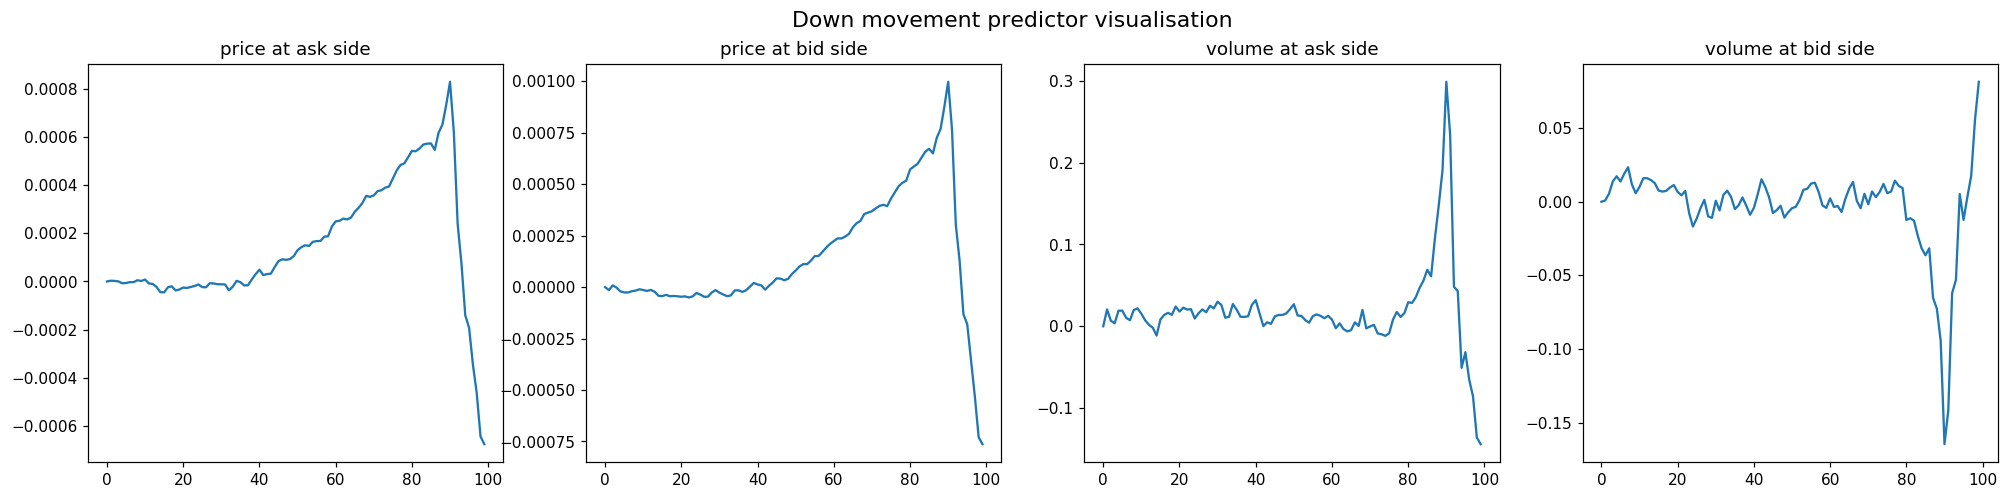

In [14]:
pyplot.tight_layout()

pyplot.figure(figsize=(22.4,4.8),dpi=110)
pyplot.suptitle(t="Down movement predictor visualisation",fontsize='x-large')

pyplot.subplot(1,4,1)
pyplot.plot(down_movement_contributor_avg[:,0], ls='-')
title(label='price at ask side')

pyplot.subplot(1,4,2)
pyplot.plot(down_movement_contributor_avg[:,2], ls='-')
title(label='price at bid side')

pyplot.subplot(1,4,3)
pyplot.plot(down_movement_contributor_avg[:,1], ls='-')
title(label='volume at ask side')

pyplot.subplot(1,4,4)
pyplot.plot(down_movement_contributor_avg[:,3], ls='-')
title(label='volume at bid side')

# Visulising what my CNN filters (at intermediate layers) were learning to specialize using Gradient Ascent

In [15]:
# Load the required packages
from keras.backend.tensorflow_backend import mean,gradients,function
from numpy.random.mtrand import random
import matplotlib.pyplot as pyplot
%matplotlib inline

from mypkg.my_normalize_gradients import normalize

In [16]:
layers_dict=dict([(layer.name,layer)for layer in restored_model.layers])
selected_layer='dense_2'
layer_output=layers_dict[selected_layer].output

magic_list=[]
for each_category in range(3):
    # print('grads = ' + str(grads))
    normalized_grads=normalize(x=gradients(loss=layer_output[:,each_category],variables=restored_model.input)[0])
    forward_and_backward_function=function(inputs=[restored_model.input],outputs=[mean(x=layer_output[:,each_category]),normalized_grads])
    # Computing Gradient Ascent
    input_signal=random(size=(1,100,40))
    alpha=1
    for i in range(1000):
        loss,grads=forward_and_backward_function(inputs=[input_signal])  # 计算L和∂L/∂x以找到使L最大的那个x
        input_signal=input_signal+alpha*grads   # 更新x
    print(f'For label {each_category}, Final loss value = {loss}')
    magic_list.append((input_signal[0],loss))

For label 0, Final loss value = 1.0
For label 1, Final loss value = 0.0
For label 2, Final loss value = 1.0


In [17]:
label_0_input_array=magic_list[0][0]    # shape=(100, 40, 1)
label_2_input_array=magic_list[2][0]

Text(0.5, 1.0, 'Level 1 ask/bid price associated with down movement prediction')

<Figure size 432x288 with 0 Axes>

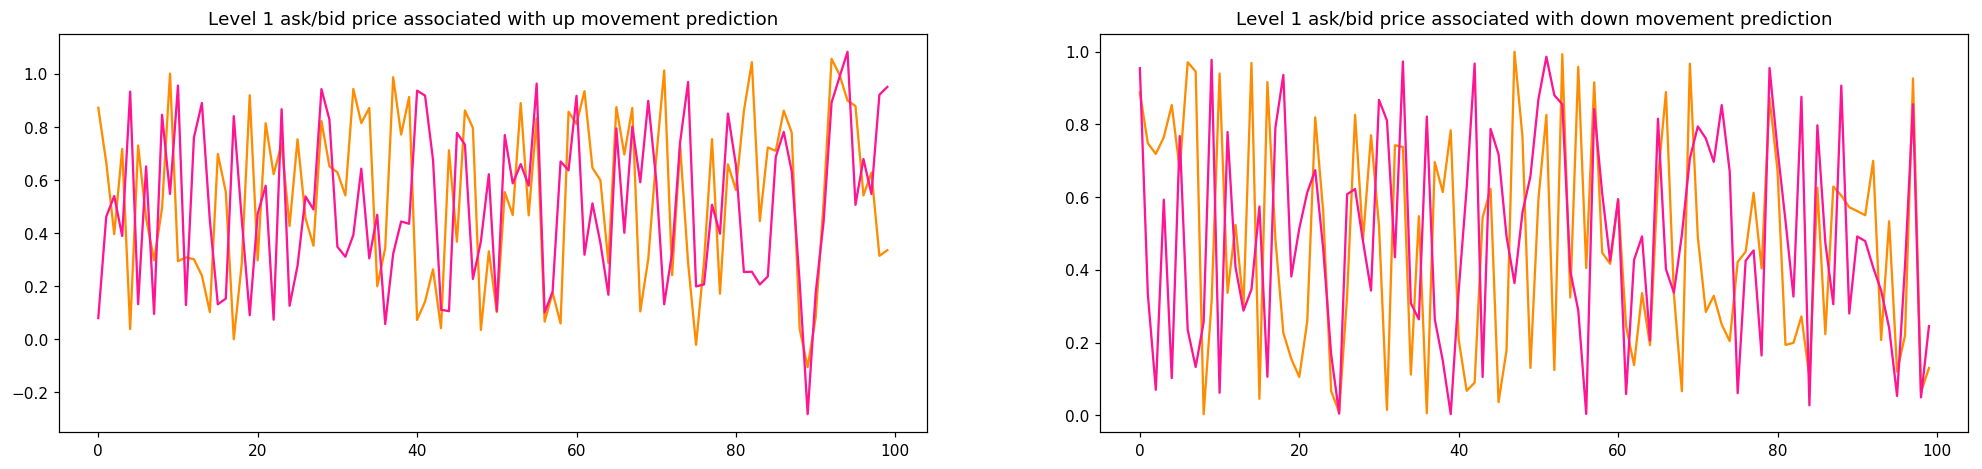

In [18]:
pyplot.tight_layout()

pyplot.figure(figsize=(22.4,4.8),dpi=110)

pyplot.subplot(1,2,1)
pyplot.plot(label_0_input_array[:,0], color='darkorange', ls='-', label='Ask price at level 1')
pyplot.plot(label_0_input_array[:,0+2], color='deeppink', ls='-', label='Bid price at level 1')
title(label='Level 1 ask/bid price associated with up movement prediction')

pyplot.subplot(1,2,2)
pyplot.plot(label_2_input_array[:,0], color='darkorange', ls='-', label='Ask price at level 1')
pyplot.plot(label_2_input_array[:,0+2], color='deeppink', ls='-', label='Bid price at level 1')
title(label='Level 1 ask/bid price associated with down movement prediction')